In [1]:
# plotting stuff
%matplotlib inline
from IPython.core.pylabtools import figsize
import seaborn as sns
from matplotlib import pyplot as plt
figsize(11, 9)


# plt.rcParams.update({'font.size': 42})
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
font = {'family' : 'Bitstream Vera Sans',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

In [2]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

# Detecting a Marketing Promotion

In the data file named marketing_promo.csv you will find data related to traffic and order activity over a period of several months. During this period a promotion offering free shipping was launched on the website. All visitors were exposed to the promotion and once started it remained active for all of the remaining days in the data you have available.
   1.	Based on the available data, deduce which day the promotion was launched.

Timeboxed: 50 mins

In [3]:
# Read in the dataset
df = pd.read_csv("./marketing_promo.csv")

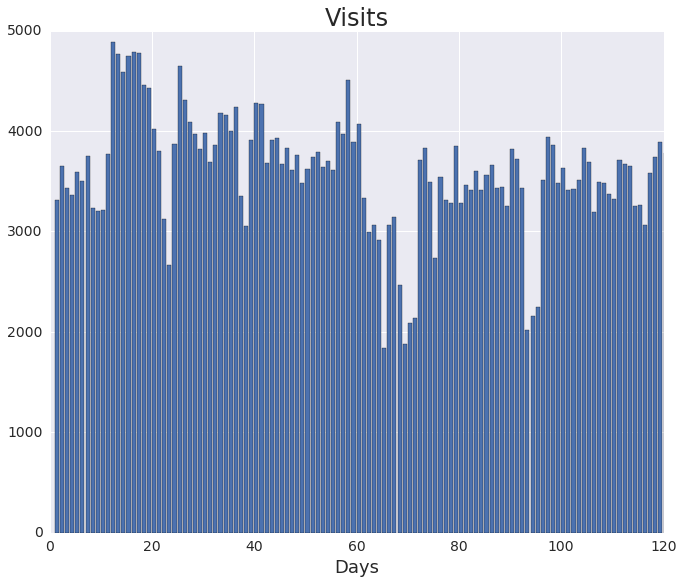

In [4]:
plt.bar(df.Day, df.visits)
plt.xlim([0, 120])
plt.title("Visits", fontsize=24)
plt.xlabel("Days", fontsize=18)

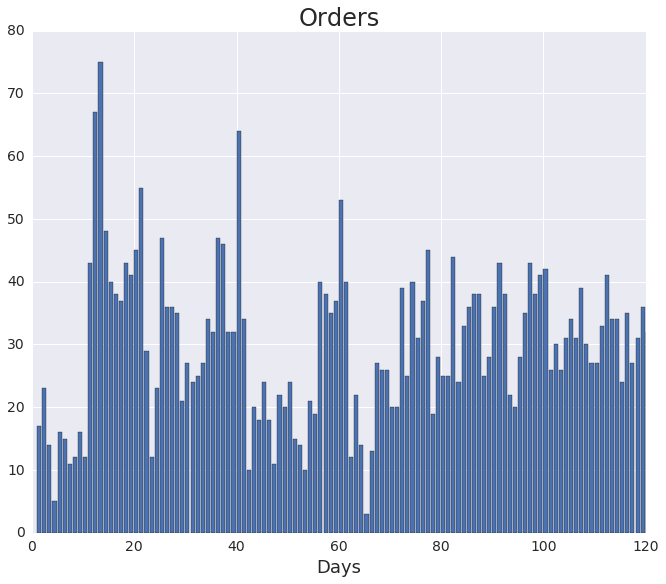

In [5]:
plt.bar(df.Day, df.orders)
plt.xlim([0, 120])
plt.title("Orders", fontsize=24)
plt.xlabel("Days", fontsize=18)

This is a perfect problem to be solved with a Bayesian approach. In fact there is an analogous problem involving SMS messaging described in Bayesian Methods For Hackers.

As a first step we will apply a Bayesian change point analysis with a Poisson prior distribution to the order data. We hypothesise here that a marketing campaign that promises free shipping will manifest it self in a change in the number of orders made.

We use a simple model of the number of orders in a day as a Possion distribution (should be reasonable as orders  are positive, integer count data)

$$ C_i \sim \text{Poisson}(\lambda)  $$

The value $\lambda$ is two valued, We define a temporal variable, $\tau$) as the switchpoint in which $\tau$ changes 

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

We model each $\lambda$ as coming from an Exponential distribution, each weakly dependent on a variable $\alpha$  
\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}

We assume a discrete uniform distribution for $\tau$. 

\begin{align}
& \tau \sim \text{DiscreteUniform(1,L) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{L}
\end{align}
where $L = 120$, the length of the time series

Encoding this all in PyMC

In [6]:
count_data = df.orders
n_count_data = len(df.orders)

In [7]:
with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)

    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau >= idx, lambda_1, lambda_2)
    
    observation = pm.Poisson("obs", lambda_, observed=count_data)
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

100%|██████████| 10000/10000 [00:01<00:00, 5765.60it/s]


In [8]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']
lambda_vals = np.hstack([lambda_1_samples, lambda_2_samples])

Plotting the distribution of the lambda values and $\tau$ we see that the highest probability (based on this analysis) is that the most likely day for the advertising campaign to have started is $T=70$ with a probability ~0.25\

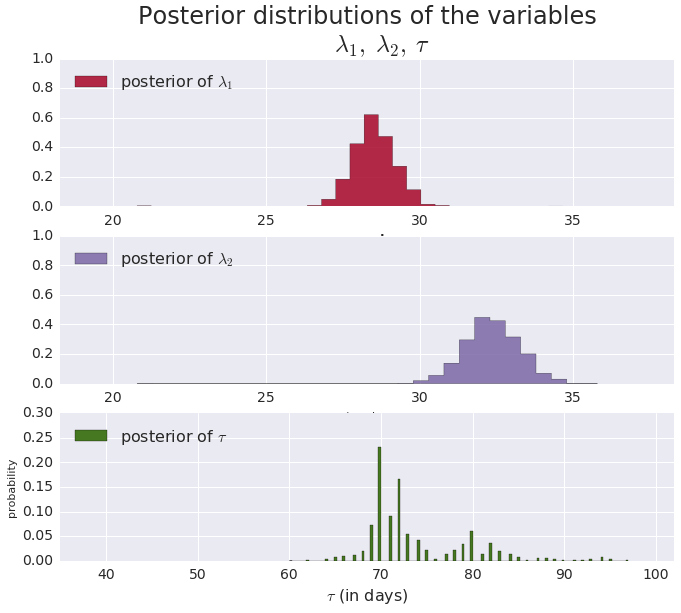

In [9]:
# Plotting code sourced from https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/tree/master/Chapter1_Introduction
# figsize(22.5, 20)
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left", fontsize=16)
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""", fontsize=24)
plt.xlim([min(lambda_vals)-2.5, max(lambda_vals)+2.5])
plt.xlabel("$\lambda_1$ value", fontsize=24)

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left", fontsize=16)
plt.xlim([min(lambda_vals)-2.5, max(lambda_vals)+2.5])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
# plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left", fontsize=16)
plt.ylim([0, .3])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)", fontsize=16)
plt.ylabel("probability");

In [10]:
N = tau_samples.shape[0]
expected_orders_per_day = np.zeros(n_count_data)

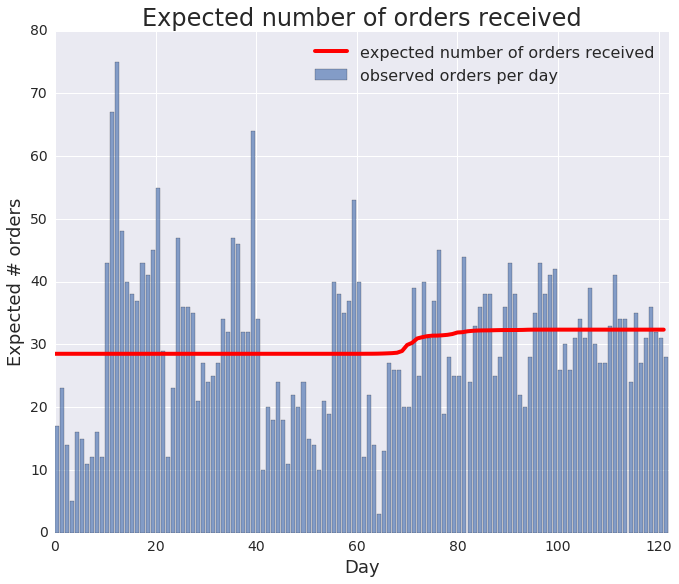

In [11]:
for day in range(0, n_count_data):
    ix = day < tau_samples
    expected_orders_per_day[day] = (lambda_1_samples[ix].sum() + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_orders_per_day, lw=4, color="r", label="expected number of orders received")
plt.xlim(0, n_count_data)
plt.xlabel("Day", fontsize=18)
plt.ylabel("Expected # orders", fontsize=18)
plt.title("Expected number of orders received", fontsize=24)
plt.bar(np.arange(len(count_data)), count_data, alpha=0.65, label="observed orders per day")

plt.legend(loc="upper right", fontsize=16);

## Extensions

I spent the rest of the timebox time working on some extensions that would improve the analysis but I didn't get time to get them working. 

### Normalised count data 
It would be kind of interesting to perform a similar analysis on the normalised order data. Instead of doing a switchpoint analysis on orders we could calculate a new quantity conversions 
        
    conversions = orders/visits

and model that as some sort of continuous distribution (maybe Gamma?)

### Goodness of fit estimate... 

It would also be worth doing a goodness of fit measure on the resulting model and get a feel for how well your model is actually capturing the data. In Chapter 2 of Bayesian methods for Hackers, Cam Davidson-Pilon has a good discussion of one such approach using graphical techniques but I don't have time here to have a go at implementing it.

# Clustering

In the data file named cluster_data.cv you will find a dataset, where each row represents a data point. The dataset is artificially generated. 
1.	Explain how you think the data was generated, including how many clusters are in the data and their centroid positions.

Timebox: 1hr

In [12]:
cols = ["a","b","c","d","e"]
df = pd.read_csv("./cluster_data.csv", usecols=cols)

In [13]:
df.head()

,a,b,c,d,e
0,0.202196,1.210328,-0.362121,6.774688,10.471171
1,-18.387879,6.307993,0.570526,-2.800453,0.791784
2,-0.353418,-2.519796,-1.434224,-2.460677,-1.848893
3,0.681851,-2.437309,-2.324559,-3.930883,0.126415
4,-1.398950,-0.306058,0.700491,1.280063,-0.367040


In [14]:
df.describe()

,a,b,c,d,e
count,800.000000,800.000000,800.000000,800.000000,800.000000
mean,-1.408342,2.481644,1.640549,3.834483,3.381425
std,6.849860,3.897975,3.548427,6.822418,7.476862
min,-19.385151,-4.982372,-5.786045,-5.583204,-7.732816
25%,-2.663111,-0.448952,-0.614847,-0.459470,-0.688404
50%,0.078303,1.242171,0.614295,1.288900,0.756951
75%,1.536407,6.478028,4.317826,5.936949,4.703692
max,10.816078,10.217713,10.108888,22.114096,22.833183


Lets have a look at the data with a scatter matrix

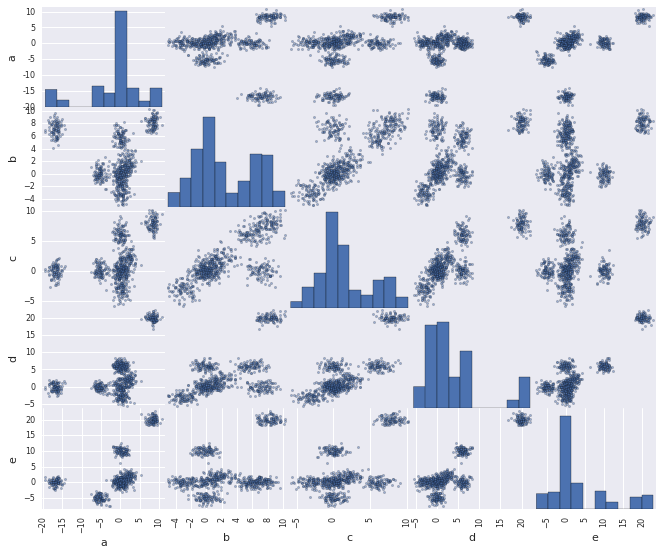

In [15]:
pd.scatter_matrix(df);

It might be worth visualising how the points are distributed. Each point exists in 5D-space. We can use a scatter matric to plot every dimension against every other dimension ... not sure how illuminating
this is. 

How was the data generated? Looks like there are around 7 (??) clusters Gaussian in shape.

We can try to model how this data was generated. 

  1. For each data point, choose cluster $i$ with probability $p_i$ (where we assume $\sum_i^N p_i = 1$.
  2. Draw a random variate from a Normal Multivariate distribution with parameters $\mathbf{\mu_i}$ and $\sigma_i$ where $i$ was chosen in step 1.
  3. Rinse and repeat for the number of points in the population.

I thought I would first try to solve this by fitting a Gaussian Mixture Model using Expectation Maximization. I test for different number of clusters and select the model that best fits the data. To assess "best fit" I use BIC 

In [16]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 12)

In [17]:
import numpy as np
import itertools

from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

In [18]:
X = df.as_matrix()  # convert to numpy array
cv_types = ['spherical', 'tied', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm

In [19]:
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

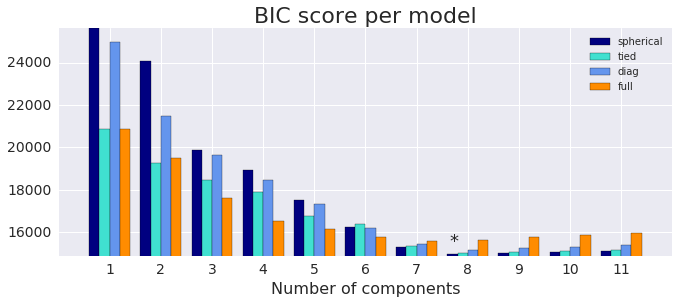

In [20]:
# Plot the BIC scores
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model', fontsize=22)
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=18)
spl.set_xlabel('Number of components', fontsize=16)
spl.legend(cv_types)

So we find the Gaussian Mixture model that best fits the data (as judged by a minimisation of the BIC criterion) is an 8 component spherical covariance gaussian. Spherical gaussian here means that the variance of each Gaussian is the same in all directions ie. symmetrical. I have to say this surpises me a bit; although its hard to picture things in 5D the scatter mtrix plot looks like some of the clusters take on cigar shapes when projected on to some dimensions. 

We can extract out the centroids of each cluster as:

In [21]:
clf.means_

array([[ -5.25564311e+00,   1.87602575e-02,   4.61179949e-02,
         -1.52566073e-01,  -5.02753596e+00],
       [  8.30188910e+00,   8.16052096e+00,   7.89498183e+00,
          1.99149216e+01,   2.00093231e+01],
       [  1.98610916e+00,   1.78870666e+00,   2.02104668e+00,
          1.99150898e+00,   2.00097805e+00],
       [ -1.67961971e+01,   7.11335351e+00,  -5.26311677e-02,
         -1.57666437e-01,   1.05269317e-01],
       [  2.33604125e-01,  -2.98874544e+00,  -3.07222776e+00,
         -3.02121929e+00,  -3.65943171e-02],
       [  2.29940557e-01,  -1.89254864e-01,  -2.02912200e-02,
          5.97371307e+00,   1.00118898e+01],
       [  8.07587029e-03,   5.79729747e+00,   6.15471634e+00,
          6.00931395e+00,  -1.31107452e-01],
       [ -1.85198396e-02,   1.20241629e-01,   1.15342056e-01,
          8.02851928e-02,   7.74210739e-02]])

## Extension


### Bayesian approach with PyMC3 

I spent the rest of the timebox time working on some extensions that would improve the analysis but I didn't get time to get them working. :(

This is a problem we could also solve by taking a Bayesian approach using a Direchlet. I used a clustering example from the PyMC3 docs (https://pymc-devs.github.io/pymc3/notebooks/dp_mix.html) as a base. I had an attempt at applying PyMC3 to the clustering problem. I largely used this example from the documentation as a base. In the time frame I gave myself I wasn't able to extend it to cover the multivariate case (using MvNormal https://pymc-devs.github.io/pymc3/api/distributions/multivariate.html). I'll put my code below for completeness though it doesn't work 

In [22]:
# K = 30

# with pm.Model() as model:
#     alpha = pm.Gamma('alpha', 1., 1.)
#     beta = pm.Beta('beta', 1., alpha, shape=K)
#     w = pm.Deterministic('w', beta * T.concatenate([[1], T.extra_ops.cumprod(1 - beta)[:-1]]))

#     tau = pm.Gamma('tau', 1., 1., shape=K)
#     lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
#     mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
#     obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
#                            observed=x_std)

# with model:
#     trace = pm.sample(2000, n_init=100000)

In [23]:
# fig, ax = plt.subplots(figsize=(8, 6))

# n_bins = 20
# ax.hist(old_faithful_df.std_waiting, bins=n_bins, lw=0, alpha=0.5);

# ax.set_xlabel('Standardized waiting time between eruptions');
# ax.set_ylabel('Number of eruptions');

In [24]:
# def stick_breaking(beta):
#     portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

#     return beta * portion_remaining

In [25]:
# with pm.Model() as model:
#     alpha = pm.Gamma('alpha', 1., 1.)
#     beta = pm.Beta('beta', 1., alpha, shape=K)
#     w = pm.Deterministic('w', stick_breaking(beta))

#     tau = pm.Gamma('tau', 1., 1., shape=K)
#     lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
#     mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
#     obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau, observed=old_faithful_df.std_waiting.values)

In [26]:
# with model:
#     trace = pm.sample(2000, n_init=50000, random_seed=2017)

In [27]:
# fig, ax = plt.subplots(figsize=(8, 6))

# plot_w = np.arange(K) + 1

# ax.bar(plot_w - 0.5, trace['w'].mean(axis=0), width=1., lw=0);

# ax.set_xlim(0.5, K);
# ax.set_xlabel('Component');

# ax.set_ylabel('Posterior expected mixture weight');

## Predicting Customer Spending

In the zip file named user_transactions.csv you will find a dataset containing the purchase history of five thousand customers who made their first purchase on Farfetch in 2012, along with a file named user_dat.csv containing data about them. It can be assumed that the first order of the customer in the dataset was their first order on Farfetch. 
1.	Fit an appropriate distribution to the order values, detailing any steps you took to arrive at the result. Give the name and parameter values of the fitted distribution.
2.	Produce a histogram of the order values and add your fitted distribution in Q1 to demonstrate the fit.

Timebx: 1hr

Load the data, have a look at the first few rows...

In [28]:
df_trans = pd.read_csv("./user_transactions.csv")
df_dat = pd.read_csv("./user_dat.csv")

In [29]:
df_trans.head()

,UserID,OrderDate_GMT,OrderValue
0,1303089,2012-08-29,302.273
1,1303089,2012-07-04,144.913
2,477723,2012-06-18,227.230
3,1303089,2012-08-29,302.273
4,4028574,2012-11-16,229.054


In [30]:
df_dat.head()

,UserID,Birthday,IsSubscribed,SubscribeDate,GenderFinal,IsVIP,HasUsedWishlist,IsUsingMultipleDevices,SK_GeoCountry
0,4527721,NaN,Yes,2012-12-12 13:52:28.757,N/D,Not VIP,No,No,216
1,4533703,NaN,Yes,2012-12-12 21:18:53.220,N/D,Not VIP,No,No,216
2,4542738,NaN,No,NaN,N/D,Not VIP,No,No,29
3,4545905,NaN,No,NaN,Women,Not VIP,Yes,Yes,216
4,4526387,1988-05-28,Yes,2015-06-25 05:37:32.363,Women,Not VIP,Yes,No,29


In [31]:
print df_dat.shape
df_dat.info()

(5021, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5021 entries, 0 to 5020
Data columns (total 9 columns):
UserID                    5021 non-null int64
Birthday                  447 non-null object
IsSubscribed              5021 non-null object
SubscribeDate             3448 non-null object
GenderFinal               5021 non-null object
IsVIP                     5021 non-null object
HasUsedWishlist           5021 non-null object
IsUsingMultipleDevices    5021 non-null object
SK_GeoCountry             5021 non-null int64
dtypes: int64(2), object(7)
memory usage: 353.1+ KB


UserID = Primary key, a lot of missing values in Birthday and a fair few for SubscribeDate.

Lets have a look at some stats + plot of OrderValue...

In [32]:
df_trans.OrderValue.describe()

count    13707.000000
mean       228.669442
std        223.284626
min          4.016000
25%         87.723000
50%        160.454000
75%        298.021000
max       3611.370000
Name: OrderValue, dtype: float64

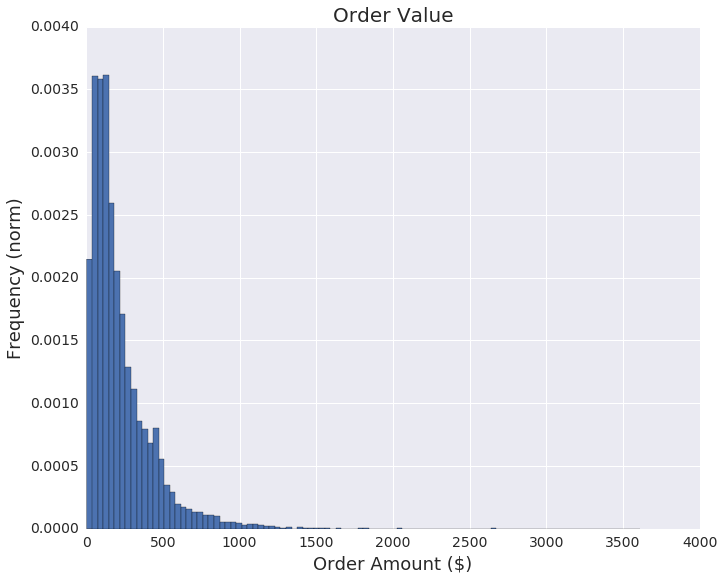

In [33]:
y = df_trans.OrderValue
plt.hist(y, bins=100, normed=True);
plt.title("Order Value", fontsize=20)
plt.xlabel("Order Amount ($)", fontsize=18)
plt.ylabel("Frequency (norm)", fontsize=18)

It's a highly skewed continuous distribution with a long tail. When fitting theoretical curves to (lets assume) empirical data I find trying a range of likely candidates and choosing the one the minimises a loss function works best. 

I'm going to use fitter ("https://pythonhosted.org/fitter/") for fitting the distributions. Fitter is a simple but very useful py package for this type of work. It is simply a helpful wrapper around the scipy.stats library with a few nice helper function.

Given the characteristics of the above distribution we pick a few likely candidates and minimise the epxectation function for each.

In [34]:
from fitter import Fitter

Fitted gamma distribution with error=1.68284741764e-06)
Fitted rayleigh distribution with error=1.21195138099e-05)


/Users/cameron2/anaconda/lib/python2.7/site-packages/scipy/stats/_continuous_distns.py:404: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*sqrt(a + b + 1) / (a + b + 2) / sqrt(a*b)
/Users/cameron2/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=1.59226193104e-06)
Fitted lognorm distribution with error=4.27914380342e-05)
Fitted wald distribution with error=9.64092269233e-07)
Fitted invgamma distribution with error=5.97058883768e-07)


/Users/cameron2/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:2225: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


,sumsquare_error
invgamma,5.970589e-07
wald,9.640923e-07
beta,1.592262e-06
gamma,1.682847e-06
rayleigh,1.211951e-05


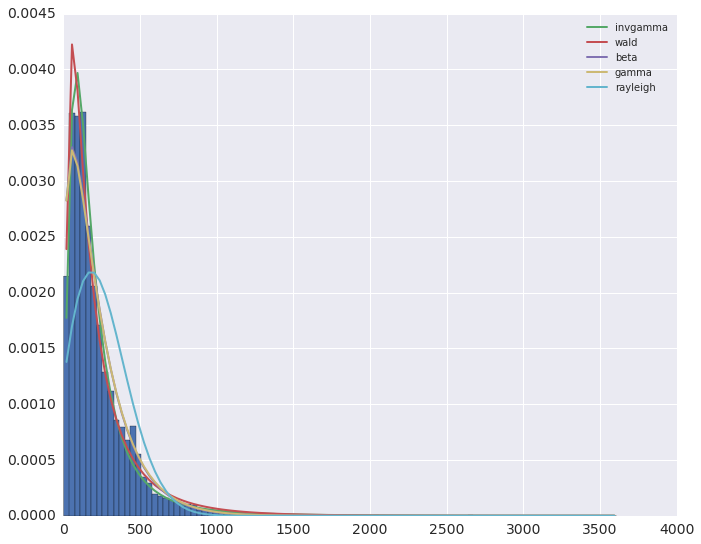

In [35]:
f = Fitter(df_trans.OrderValue, distributions=['gamma', 'rayleigh', "beta", "lognorm", "wald", "invgamma"])
f.fit()
f.summary()

The distribution that minimises the sum of squares error in this case is the inverse gamma distribution. We can obtain the parameters as a one-liner

In [36]:
f.fitted_param["invgamma"]

(2.9096684681865224, -58.341540015771599, 562.5602631256811)

From the scipy.stats documentation (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.invgamma.html) these values correspond to mean, alpha, beta

### 3) Predict the total spend for all customers for 2014

Ok, lets see what data we have ... 

In [37]:
df_trans['OrderDate_GMT'] = pd.to_datetime(df_trans['OrderDate_GMT'])

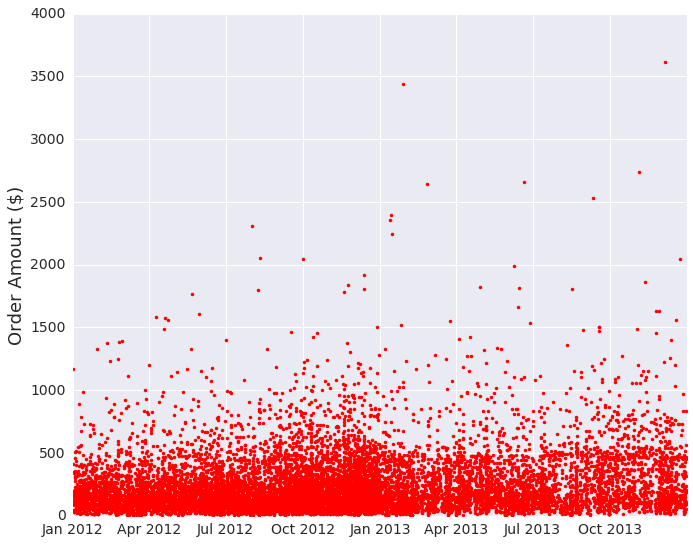

In [38]:
plt.plot(df_trans.OrderDate_GMT, df_trans.OrderValue, 'r.')
plt.ylabel("Order Amount ($)", fontsize=18)

We have data spanning two years, 2012 and 2013 for customers who made there first purchase in 2012. We would like to predict how much will be spent in 2014. 

The simplest approach would be to assume customers spending will follow the "inverse gaussian" distribution we fitted previously. Then the problem simply becomes a frequency modelling problem. We predict the total number of orders in 2014 and then sample the distribution with that count to get a value estimate.

Lets see how the number of order each month has changed with time...

In [39]:
df_trans["order_count"] = df_trans.sort_values("OrderDate_GMT", ascending=True).groupby("UserID").cumcount()
df_trans["first_order"] = df_trans["order_count"]==0

In [40]:
first_order = df_trans[df_trans["first_order"]==1]
not_first_order = df_trans[df_trans["first_order"]==0]
df2 = first_order.groupby([first_order["OrderDate_GMT"].dt.year, first_order["OrderDate_GMT"].dt.month])["UserID"].count()
df2.rename("first_order", inplace=True)
df3 = not_first_order.groupby([not_first_order["OrderDate_GMT"].dt.year, not_first_order["OrderDate_GMT"].dt.month])["UserID"].count()
df3.rename("not_first_order", inplace=True);

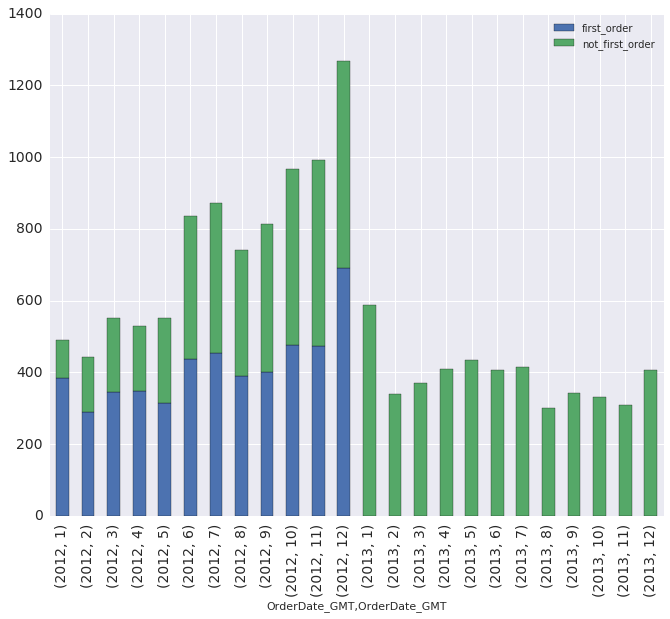

In [41]:
pd.concat([df2, df3], axis=1).plot(kind="bar", stacked=True)

There is a very cool package called Lifetimes (https://github.com/CamDavidsonPilon/lifetimes) that performs a  survival analysis on customer purchase history. We use it here to predict the number of purchases we can expect from the customer base over the next 365 days and then use that number to sample the fitted inverse gamma distribution.

To do this I'll take the data we have and aggregate it to a summary level, calculating frequency, recency and age (T)

 * frequency represents the number of repeat purchases the customer has made. This means that it's one less than the total number of purchases.
 * T represents the age of the customer in whatever time units chosen (weekly above). This is equal to the duration between a customer's first purchase and the end of the period under study.
 * recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer's first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)


In [42]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

In [43]:
#? summary_data_from_transaction_data

In [44]:
summary = summary_data_from_transaction_data(df_trans, 'UserID', 'OrderDate_GMT', monetary_value_col="OrderValue", observation_period_end='2013-12-31')

/Users/cameron2/anaconda/lib/python2.7/site-packages/lifetimes/utils.py:113: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  transactions = transactions[select_columns].sort(select_columns).copy()


We fit a BG/NBD model with this summarised data

In [45]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print bgf

<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 0.59, alpha: 50.27, b: 1.94, r: 0.16>


In [46]:
from lifetimes.plotting import plot_frequency_recency_matrix

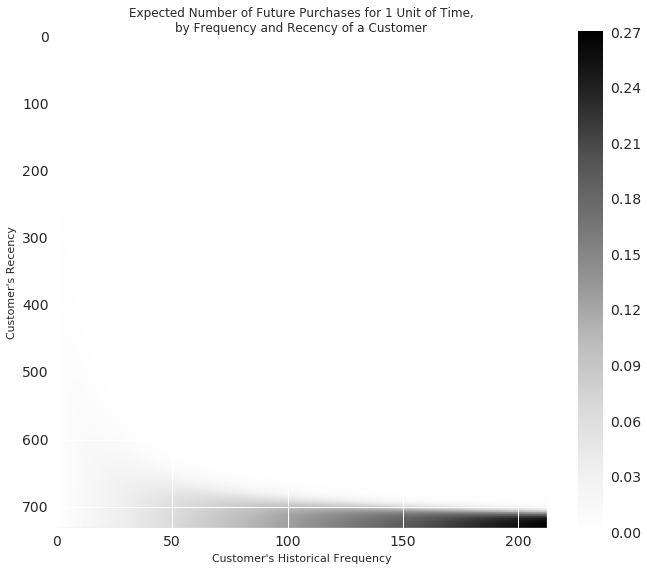

In [47]:
plot_frequency_recency_matrix(bgf)

In [48]:
from lifetimes.plotting import plot_probability_alive_matrix

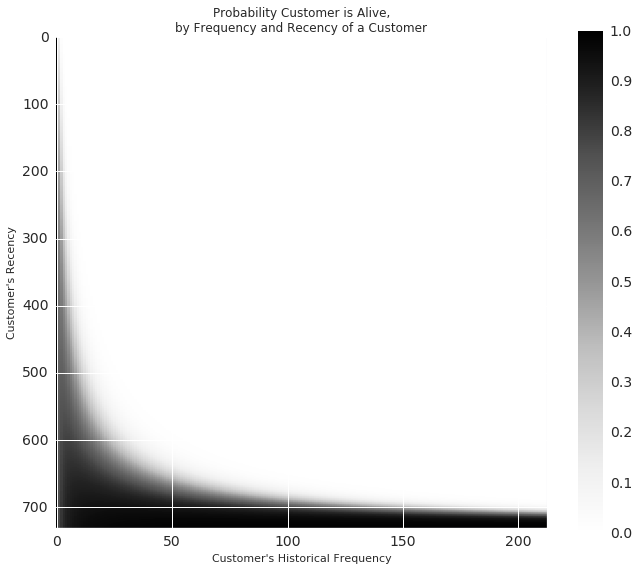

In [49]:
plot_probability_alive_matrix(bgf)

In [50]:
t = 365  # we want an estimate of number of purchases over next year
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
UserID,,,,,
3146981,31.0,469.0,474.0,167.906839,18.013704
673620,55.0,690.0,717.0,786.836927,21.648458
1243594,57.0,689.0,689.0,480.794632,24.716326
3486009,81.0,447.0,447.0,994.754395,49.804827
1303089,212.0,623.0,623.0,632.340821,100.254579


In [51]:
number_of_purchases2014 = summary['predicted_purchases'].sum()
print "Number of expected purchases will be: ", number_of_purchases2014

Number of expected purchases will be:  2181.69638347


Ok, so the Lifetime model predicts there will be ~2182 purchases made in the next 365 days. As a really quick and dirty estimate lets just take that many draws from our fitted inverse-gamma distribution (I really should work out the Expectation value here?)

In [52]:
from pylab import linspace, plot
import scipy.stats
dist = scipy.stats.invgamma

In [53]:
dist = stats.invgamma
param = (2.9096684681865224, -58.341540015771599, 562.5602631256811)
r = dist.rvs(param[0], param[1], param[2], size=number_of_purchases2014)
print "Total expected spend for 2014:", r.sum()

Total expected spend for 2014: 513799.608886


So we expect a spend of around £500 000.

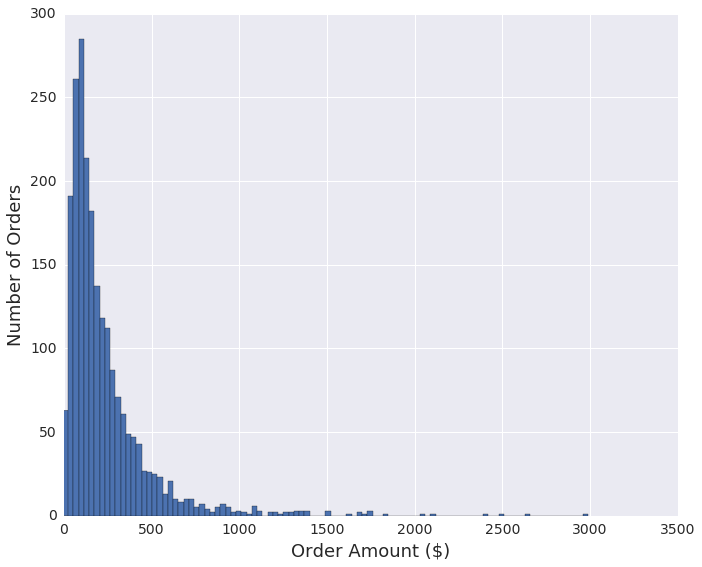

In [54]:
plt.hist(r, bins=100);
plt.xlim([0, 3500])
plt.ylabel("Number of Orders", fontsize=18)
plt.xlabel("Order Amount ($)", fontsize=18)

### 4)	Explain the strengths and weaknesses of the approach you have taken in Q3 and the assumptions you have made. How could the prediction be improved?

The simple approach used here splits the frequency (number of purchases in a time period $t$) and severity (amount spent per purchase) into two independent models. We have no reason to expect that this should be the case. Plotting the correlation between the frequency and monetary_value (total spend) in the data we observe a slight positive correlation (more frequent shoppers make larger purchases). This slight positive correlation invalidates our independence assumption - but as it is fairly low its unlikely to have a terminal affect on the model quality and it's a useful simplifying approximation

In [55]:
summary[["frequency", "monetary_value"]].corr()

,frequency,monetary_value
frequency,1.000000,0.273129
monetary_value,0.273129,1.000000


We also havn't had the time to incorporate any of the other features contained in the user_dat.csv file. One could imagine building a more preditice survival analysis model that incirporates some more of these redictive features.

The Lifetimes py package also offers a Gamma-Gamma model for assessing customer value. It would be interesting to apply it to the data as an alyernative to the fitted inverse gamma model.

In [56]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()